<a href="https://colab.research.google.com/github/joherra/MyApplication/blob/master/Proyecto%202.3.%20Optimizaci%C3%B3n%20del%20Scheduling%20de%20Bobinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 3/3)

El objetivo inicial de este proyecto fue el desarrollo de modelos predictivos tanto de consignas del horno (THC1, THC3 y THC5) como de comportamiento de la bobina de acero (TMPP2).

¿Cómo podemos usar estos modelos en la toma de decisiones?

Imaginemos, que queremos procesar nuevas bobinas y sabemos que un tratamiento de temperatura homogéneo es crucial para reducir los problemas de adherencia de la capa de zinc. De este modo, el jefe de producción **nos pide que, para maximizar la producción, organicemos las bobinas que tenemos que procesar mañana considerando una velocidad constante de 180 metros por minuto. Pero además, para reducir problemas en el recubrimiento de zinc, el orden (*scheduling*) de las bobinas deberá ser hecho de la mejor forma posible, de modo que los cambios en las temperaturas de consigna de THC1 se minimicen para evitar problemas en el tratamiento térmico**. 

En esta tercera parte, vamos a aprender cómo utilizar los modelos de machine learning para simular el proceso industrial y optimizarlo en base a unas especificaciones previas.

Las bobinas a procesar en el futuro próximo corresponden con las 81 bobinas de la base de datos de testeo por lo que, en un hipotético caso real, **solo dispondríamos de la información relativa a cada bobina (dimensiones, tipo de acero) y los datos objetivos (velocidad objetivo y temperatura objetivo que tiene que alcanzar la bobina a la salida del horno según la curva de recocido de cada tipo de acero)**.

In [1]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

## Funciones

In [2]:
# Dibuja datos del proceso
def dibuja_proceso(df, pos_ini = 0, num_bobs = None):
    if num_bobs==None:
        num_bobs = len(df)
    # Dibuja Espesor y Ancho con dos ejes
    # -----------------------------------
    df_plot = df.iloc[pos_ini:pos_ini+num_bobs]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
    ax.plot(df_plot['ESPESOR'], label='ESPESOR')
    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Espesor (mm.)')
    # Segundo eje
    ax.plot(df_plot['ANCHO']/1000.0, label='ANCHO')
    def CtoF(x):
        return x * 1000.0
    def FtoC(x):
        return x / 1000.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Ancho (mm.)')
    ax.legend()

    # Dibuja Temperaturas y Velocidad con dos ejes
    # -----------------------------------
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    for colname in df_plot.columns[7:]:
        ax.plot(df_plot[colname], label=colname)

    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Temperaturas (ºC)')

    ax.plot(df_plot['VELMED']*3.0, label='VELMED')
    def CtoF(x):
        return x / 3.0
    def FtoC(x):
        return x * 3.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Velocidad Media (m/min)')
    ax.legend()

# Dibuja predicciones de un modelo
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()
    
# Dibuja cuatro graficas de preds vs real 
def saca_predicciones(y_true, y_pred):
    errores = y_true-y_pred
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplot(2,2,1)
    sns.distplot(errores, hist=False)
    plt.title('MEDIA={:,.3f}, STD={:,.3f}'.format(np.mean(errores),np.std(errores)))
    plt.xlabel('Error')
    plt.ylabel('Prob')
    
    plt.subplot(2,2,2)
    sns.distplot(errores, kde=False)
    plt.title('MIN_ABS={:,.3f}, MAX_ABS={:,.3f}'.format(np.min(np.abs(errores)),np.max(np.abs(errores))))
    plt.xlabel('Error')
    plt.ylabel('Num')
    
    plt.subplot(2,2,3)
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true[np.argsort(y_true)],y_pred[np.argsort(y_true)],alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    
    ax1 = plt.subplot(2,2,4)
    df = pd.DataFrame({'Real':y_true,'Prediccion':y_pred})
    sns.kdeplot(df.Real, df.Prediccion, ax=ax1)
    sns.rugplot(df.Real, color="g", ax=ax1)
    sns.rugplot(df.Prediccion, vertical=True, ax=ax1)


# Función que obtiene el MAE, RMSE y R2 de VC con repetición y para la base de datos de testeo
def entrena_model(model, num_folds=5, num_bags=10):
    np.random.seed(2020)
    X_tot = df_train_esc.copy()
    y_tot = df_train_limpia[target].values.reshape(-1)
    X_test = df_test_esc.copy()
    y_test = df_test[target].values.reshape(-1)
    
    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot),num_bags))
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test),num_bags*num_folds))
    preds_test[:] = np.nan
    # Entrena y extrae la predicciones con validación cruzada repetida
    
    folds = RepeatedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=2020)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        model.fit(X_train, y_train)
        preds_val[val_index,nbag] = model.predict(X_val)
        preds_test[:,niter] = model.predict(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=1) 
    preds_test_mean = preds_test.mean(axis=1)
    
    # Extrae las métricas
    mae_val = mean_absolute_error(y_tot, preds_val_mean) 
    rmse_val = np.sqrt(mean_squared_error(y_tot, preds_val_mean))
    r2_val = r2_score(y_tot, preds_val_mean)
    
    mae_tst = mean_absolute_error(y_test, preds_test_mean) 
    rmse_tst = np.sqrt(mean_squared_error(y_test, preds_test_mean))
    r2_tst = r2_score(y_test, preds_test_mean)
    
    return mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_tot, preds_val_mean, y_test, preds_test_mean, preds_val, preds_test

## Leemos la Base de Datos y Preprocesamos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-05-02 23:43:48--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-05-02 23:43:48--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.02s   

2021-05-02 23:43:48 (5.60 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-05-02

In [4]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')

df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500
display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


## Definición del Problema

Las bobinas a procesar son las que tenemos en la base de datos de testeo.

El jefe de producción no indica que necesitamos mejorar el proceso de producción **aumentando la velocidad de producción a 180 metros por minuto**. Para ello, tenemos que determinar las cosignas de THC1, THC3, THC5 que permitan poder procesar las bobinas de forma óptima.

Así mismo, nos pide que **reorganicemos el scheduling de las mismas para que los cambios en THC1 sean lo menos bruscos posibles**.

Imaginemos, que las bobinas no han sido tratadas aún y que **solo disponemos de las variables correspondientes a la bobina (CLASACERO, ANCHO, ESPESOR, LARGO, PESO), la temperatura a la que tiene que salir la bobina del horno (TMPP2CNG), que proviene de la curva de recocido del tipo de acero, y la velocidad objetivo que es VELMED=180.** 

Es decir, de la base de datos de testeo tenemos que cambiar o eliminar la siguiente información.


(81, 13)


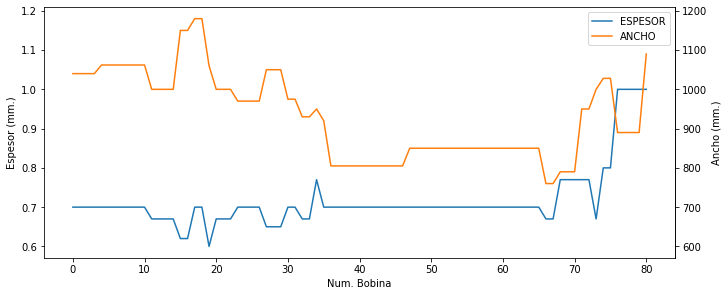

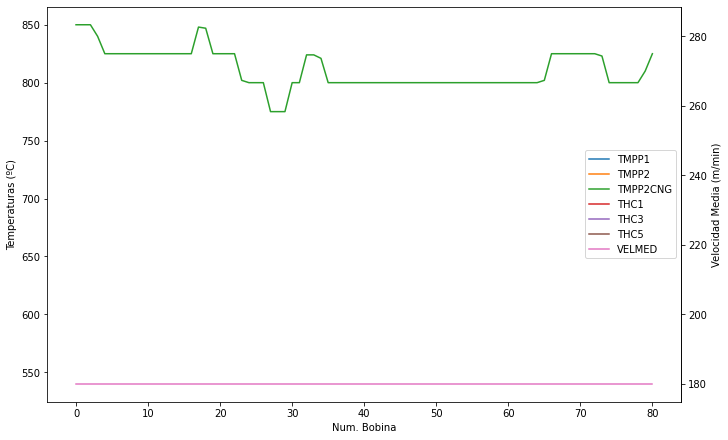

In [5]:
# Recogemos los datos de la base de datos de testeo y eliminamos aquellos que no podríamos saber.
df_test_sin_procesar = df_test.copy()
df_test_sin_procesar['VELMED'] = 180.0 #El objetivo es producir a 180m/min
df_test_sin_procesar['THC1'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['THC3'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['THC5'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['TMPP1'] = np.nan #No disponemos de ella previamente
df_test_sin_procesar['TMPP2'] = np.nan #No disponemos de ella previamente
print(df_test_sin_procesar.shape)
dibuja_proceso(df_test_sin_procesar)

**El objetivo es conseguir un tratamiento de temperatura de THC1 lo más homogéneo posible para reducir los problemas debidos a cambios bruscos de temperatura en el tratamiento de las bobinas**

Como THC3 y THC5 están muy correladas con THC1, es posible que al reducir los saltos en THC1 se reduzcan los saltos en THC3 y THC5.

Después de la reunión con los tecnólogos de la empresa se decide realizar los siguientes pasos:

1. Crear los mejores modelos A posibles para THC1, THC3 y THC5, usando la metodología utilizada en la parte 2 (Proyecto 2.2).
2. Crear un modelo B, que permita predecir la temperatura de salida de la bobina (TMPP2) a partir de las características de la bobina (CLASACERO, ANCHO, ESPESOR), THC1, THC3, THC5 y VELMED.
3. Determinar los valores de THC1, THC3, THC5 para cada bobina si queremos tratarlas a VELMED=180.
4. Una vez tenemos THC1, THC3, THC5, usar el modelo B para calcular TMPP2.
5. Mediante simulación, usar diferentes estrategias para reorganizar el orden (*scheduling*) de las bobinas con el objetivo de minimizar los saltos de temperatura de TMPP2 entre bobinas. 

## Creación de los Modelos para predecir la temperatura en las zonas 1, 3, y 5 del horno (THC1, THC3, THC5)

Creamos la base de datos poniendo VELMED=180 en la de testeo. Así, las predicciones de THC1, THC3 y THC5 de los modelos serán con la velocidad objetivo de 180 metros por minuto.

In [6]:
df_train_limpia = df_train.loc[np.abs(df_train['TMPP2CNG']-df_train['TMPP2'])<=25].copy()
df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_test_cat['VELMED'] = 180.0 #Ponemos a 180 la base de datos de testeo para obtener las THC1, THC3, THC5

selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP2CNG'] + list(df_dummies.columns)

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
print(df_train_esc.shape, df_test_esc.shape)

(1851, 50) (81, 50)


**EJERCICIO: Usando la metodología del Proyecto 2.2., desarrollar modelos precisos para THC1, THC3, THC5. Para crear los modelos de THC3 y THC5, se seleccionarán las variables y mejor algoritmo elegido para THC1 en el paso previo. Usar todas las celdas necesarias. Los modelos tienen que llamarse: modelo_thc1, modelo_thc3, modelo_thc5**

Como ejemplo se muestra el uso de un modelo lineal básico, *Ridge*. **El alumno deberá usar el mejor algoritmo, seleccionando los parámetros más adecuados para cada modelo**. El proceso de selección se realizará según la metodología usada en el paso anterior (Proyecto 3.2).

In [7]:
#Creados a partir de lso mejores resultados de la parte 2.2
# Ejemplo Modelo THC1 con DecisionTreeRegressor
target = ['THC1']
modelo_thc1 = DecisionTreeRegressor(min_samples_split=0.004,splitter="random",criterion="friedman_mse")
_, _, _, _, _, _, _, _, y_test1, preds_test1, val_mat, tst_mat = entrena_model(modelo_thc1, num_folds=15)
# Ejemplo Modelo THC3 con DecisionTreeRegressor
target = ['THC3']
modelo_thc3 = DecisionTreeRegressor(min_samples_split=0.004,splitter="random",criterion="friedman_mse")
_, _, _, _, _, _, _, _, y_test3, preds_test3, val_mat, tst_mat = entrena_model(modelo_thc3, num_folds=15)
# Ejemplo Modelo THC5 con DecisionTreeRegressor
target = ['THC5']
modelo_thc5 = DecisionTreeRegressor(min_samples_split=0.004,splitter="random",criterion="friedman_mse")
_, _, _, _, _, _, _, _, y_test5, preds_test5, val_mat, tst_mat = entrena_model(modelo_thc5, num_folds=15)

## Creación del Modelo B para predecir la temperatura de salida de la banda de acero

Creamos la base de datos modificando THC1, THC3, THC5 que han sido obtenidos con los modelos anteriores. Así mismo, ponemos VELMED=180. En este caso, **no eliminamos los casos cuya diferencia sea mayor de 25ºC**, pues queremos aprender el comportamiento de la banda de acero antes los diversos puntos de operación del proceso.

In [8]:
df_train_limpia = df_train.copy()
df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))
df_train_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_test_cat['VELMED'] = 180.0 #Velocidad Prefijada
df_test_cat['THC1'] = preds_test1 #Predicción del modelo_thc1
df_test_cat['THC3'] = preds_test3 #Predicción del modelo_thc3
df_test_cat['THC5'] = preds_test5 #Predicción del modelo_thc5

selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'THC1', 'THC3', 'THC5'] + list(df_dummies.columns)

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_cat[selec_features].values)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
print(df_train_esc.shape)

(1894, 52)


**EJERCICIO: Usando la metodología del Proyecto 2.2., desarrollar un modelo preciso para TMPP2. El modelo se llamará: modelo_tmpp2**

Como ejemplo usamos uno básico, *Ridge*. 

El alumno deberá buscar el mejor modelo con cada uno de los algoritmos anteriores. El proceso de selección se realizará según la metodología usada en el paso anterior (Proyecto 2.2).

Realizar una Tabla con los mejores resultados de validación cruzada obtenidos con cada algoritmo.

In [9]:
#Lineal de Ridge Regression
target = ['TMPP2']
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
  model_tmpp2 = Ridge(alpha=alpha)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   RIDGE con alpha=1.0e-02 ->    Val:[MAE=6.452,RMSE=8.797,R2=0.925]     Test:[MAE=32.128,RMSE=32.557,R2=-2.500]
MODELO B ->   RIDGE con alpha=2.0e-02 ->    Val:[MAE=6.452,RMSE=8.797,R2=0.925]     Test:[MAE=32.125,RMSE=32.554,R2=-2.499]
MODELO B ->   RIDGE con alpha=4.0e-02 ->    Val:[MAE=6.452,RMSE=8.797,R2=0.925]     Test:[MAE=32.119,RMSE=32.548,R2=-2.498]
MODELO B ->   RIDGE con alpha=7.9e-02 ->    Val:[MAE=6.452,RMSE=8.797,R2=0.925]     Test:[MAE=32.109,RMSE=32.538,R2=-2.496]
MODELO B ->   RIDGE con alpha=1.6e-01 ->    Val:[MAE=6.452,RMSE=8.797,R2=0.925]     Test:[MAE=32.087,RMSE=32.516,R2=-2.491]
MODELO B ->   RIDGE con alpha=3.2e-01 ->    Val:[MAE=6.453,RMSE=8.797,R2=0.925]     Test:[MAE=32.044,RMSE=32.474,R2=-2.482]
MODELO B ->   RIDGE con alpha=6.3e-01 ->    Val:[MAE=6.454,RMSE=8.797,R2=0.925]     Test:[MAE=31.960,RMSE=32.390,R2=-2.464]
MODELO B ->   RIDGE con alpha=1.3e+00 ->    Val:[MAE=6.457,RMSE=8.798,R2=0.925]     Test:[MAE=31.795,RMSE=32.227,R2=-2.429]
MODELO B

In [10]:
#K-NN
target = ['TMPP2']
for n_neighbors in range(8):
  model_tmpp2 = KNeighborsClassifier(n_neighbors=n_neighbors+1)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  KNN con k={} vecinos -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(n_neighbors+1, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   KNN con k=1 vecinos ->     Val:[MAE=5.005,RMSE=9.554,R2=0.912]     Test:[MAE=6.450,RMSE=12.429,R2=0.490]
MODELO B ->   KNN con k=2 vecinos ->     Val:[MAE=5.320,RMSE=9.844,R2=0.906]     Test:[MAE=6.626,RMSE=12.660,R2=0.471]
MODELO B ->   KNN con k=3 vecinos ->     Val:[MAE=5.872,RMSE=10.638,R2=0.891]     Test:[MAE=6.739,RMSE=12.701,R2=0.467]
MODELO B ->   KNN con k=4 vecinos ->     Val:[MAE=6.282,RMSE=11.401,R2=0.875]     Test:[MAE=7.269,RMSE=12.852,R2=0.455]
MODELO B ->   KNN con k=5 vecinos ->     Val:[MAE=6.565,RMSE=11.869,R2=0.864]     Test:[MAE=8.295,RMSE=13.837,R2=0.368]
MODELO B ->   KNN con k=6 vecinos ->     Val:[MAE=6.644,RMSE=12.025,R2=0.860]     Test:[MAE=8.348,RMSE=13.928,R2=0.359]
MODELO B ->   KNN con k=7 vecinos ->     Val:[MAE=6.797,RMSE=12.332,R2=0.853]     Test:[MAE=8.418,RMSE=14.105,R2=0.343]
MODELO B ->   KNN con k=8 vecinos ->     Val:[MAE=6.864,RMSE=12.430,R2=0.851]     Test:[MAE=9.032,RMSE=14.420,R2=0.313]


In [11]:
#SVR
target = ['TMPP2']
for num_neuronas in [0.0001,0.001,0.01,0.1,1]:
  model_tmpp2 = SVR(kernel='rbf', gamma=num_neuronas)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   ANN con num_neuronas=0.0001 ->     Val:[MAE=23.606,RMSE=34.099,R2=-0.122]     Test:[MAE=16.370,RMSE=19.089,R2=-0.203]
MODELO B ->   ANN con num_neuronas=0.001 ->     Val:[MAE=19.027,RMSE=26.682,R2=0.313]     Test:[MAE=11.848,RMSE=13.950,R2=0.357]
MODELO B ->   ANN con num_neuronas=0.01 ->     Val:[MAE=10.368,RMSE=13.865,R2=0.814]     Test:[MAE=6.826,RMSE=9.493,R2=0.702]
MODELO B ->   ANN con num_neuronas=0.1 ->     Val:[MAE=9.287,RMSE=14.761,R2=0.790]     Test:[MAE=10.585,RMSE=14.250,R2=0.330]
MODELO B ->   ANN con num_neuronas=1 ->     Val:[MAE=12.433,RMSE=20.476,R2=0.595]     Test:[MAE=14.925,RMSE=17.470,R2=-0.008]


In [12]:
#MLPRegressor
#Da errores
#target = ['TMPP2']

#for num_neuronas in np.arange(12,21,1):
#  model_tmpp2 = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
#  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
#  print('MODELO B -> \
#  ANN con num_neuronas={} -> \
#    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
#    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,mae_val, rmse_val, r2_val, 
#                                                      mae_tst, rmse_tst, r2_tst))

In [13]:
#ExtraTreeClassifier
from sklearn.tree import ExtraTreeClassifier
target = ['TMPP2']
#hasta 0.15 que es ascendente todo el rato
for num_neuronas in np.arange(0.001,0.15,0.003):
  model_tmpp2 = ExtraTreeClassifier(min_samples_split=num_neuronas)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   ANN con num_neuronas=0.001 ->     Val:[MAE=4.461,RMSE=7.314,R2=0.948]     Test:[MAE=5.062,RMSE=6.467,R2=0.862]
MODELO B ->   ANN con num_neuronas=0.004 ->     Val:[MAE=5.671,RMSE=9.204,R2=0.918]     Test:[MAE=5.807,RMSE=7.796,R2=0.799]
MODELO B ->   ANN con num_neuronas=0.007 ->     Val:[MAE=5.859,RMSE=9.344,R2=0.916]     Test:[MAE=4.706,RMSE=7.157,R2=0.831]
MODELO B ->   ANN con num_neuronas=0.010000000000000002 ->     Val:[MAE=5.996,RMSE=9.641,R2=0.910]     Test:[MAE=4.002,RMSE=6.387,R2=0.865]
MODELO B ->   ANN con num_neuronas=0.013000000000000001 ->     Val:[MAE=6.194,RMSE=9.826,R2=0.907]     Test:[MAE=4.170,RMSE=6.338,R2=0.867]
MODELO B ->   ANN con num_neuronas=0.016 ->     Val:[MAE=6.171,RMSE=9.941,R2=0.905]     Test:[MAE=4.103,RMSE=6.094,R2=0.877]
MODELO B ->   ANN con num_neuronas=0.019000000000000003 ->     Val:[MAE=6.273,RMSE=9.944,R2=0.905]     Test:[MAE=3.623,RMSE=5.703,R2=0.893]
MODELO B ->   ANN con num_neuronas=0.022000000000000002 ->     Val:[MAE=6.485,RM

In [14]:
#DecisionTreeRegressor
target = ['TMPP2']
for num_neuronas in np.arange(0.001,0.15,0.003):
  model_tmpp2 = DecisionTreeRegressor(min_samples_split=num_neuronas)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   ANN con num_neuronas=0.001 ->     Val:[MAE=4.429,RMSE=7.630,R2=0.944]     Test:[MAE=5.858,RMSE=10.589,R2=0.630]
MODELO B ->   ANN con num_neuronas=0.004 ->     Val:[MAE=4.364,RMSE=7.552,R2=0.945]     Test:[MAE=6.172,RMSE=10.398,R2=0.643]
MODELO B ->   ANN con num_neuronas=0.007 ->     Val:[MAE=4.421,RMSE=7.545,R2=0.945]     Test:[MAE=5.797,RMSE=10.263,R2=0.652]
MODELO B ->   ANN con num_neuronas=0.010000000000000002 ->     Val:[MAE=4.645,RMSE=7.773,R2=0.942]     Test:[MAE=6.262,RMSE=10.500,R2=0.636]
MODELO B ->   ANN con num_neuronas=0.013000000000000001 ->     Val:[MAE=4.695,RMSE=7.860,R2=0.940]     Test:[MAE=5.746,RMSE=10.441,R2=0.640]
MODELO B ->   ANN con num_neuronas=0.016 ->     Val:[MAE=4.891,RMSE=8.240,R2=0.934]     Test:[MAE=5.977,RMSE=10.543,R2=0.633]
MODELO B ->   ANN con num_neuronas=0.019000000000000003 ->     Val:[MAE=4.946,RMSE=8.313,R2=0.933]     Test:[MAE=6.489,RMSE=10.595,R2=0.629]
MODELO B ->   ANN con num_neuronas=0.022000000000000002 ->     Val:[MAE=5

In [15]:
#DecisionTreeRegressor
#Muy lento
target = ['TMPP2']
for num_neuronas in np.arange(0.001,0.015,0.003):
  model_tmpp2 = DecisionTreeRegressor(min_samples_split=num_neuronas,splitter="random",criterion="mae")
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   ANN con num_neuronas=0.001 ->     Val:[MAE=4.208,RMSE=7.104,R2=0.951]     Test:[MAE=5.689,RMSE=7.624,R2=0.808]
MODELO B ->   ANN con num_neuronas=0.004 ->     Val:[MAE=4.264,RMSE=7.189,R2=0.950]     Test:[MAE=6.927,RMSE=8.593,R2=0.756]
MODELO B ->   ANN con num_neuronas=0.007 ->     Val:[MAE=4.494,RMSE=7.618,R2=0.944]     Test:[MAE=6.597,RMSE=8.365,R2=0.769]
MODELO B ->   ANN con num_neuronas=0.010000000000000002 ->     Val:[MAE=4.693,RMSE=7.775,R2=0.942]     Test:[MAE=5.609,RMSE=7.923,R2=0.793]
MODELO B ->   ANN con num_neuronas=0.013000000000000001 ->     Val:[MAE=4.778,RMSE=7.941,R2=0.939]     Test:[MAE=5.150,RMSE=7.808,R2=0.799]


In [16]:
#DecisionTreeRegressor
target = ['TMPP2']
for num_neuronas in np.arange(0.001,0.15,0.003):
  model_tmpp2 = DecisionTreeRegressor(min_samples_split=num_neuronas,splitter="random",criterion="friedman_mse")
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
  print('MODELO B -> \
  ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

MODELO B ->   ANN con num_neuronas=0.001 ->     Val:[MAE=4.242,RMSE=7.224,R2=0.950]     Test:[MAE=3.727,RMSE=6.032,R2=0.880]
MODELO B ->   ANN con num_neuronas=0.004 ->     Val:[MAE=4.316,RMSE=7.253,R2=0.949]     Test:[MAE=3.904,RMSE=6.101,R2=0.877]
MODELO B ->   ANN con num_neuronas=0.007 ->     Val:[MAE=4.392,RMSE=7.270,R2=0.949]     Test:[MAE=4.315,RMSE=6.716,R2=0.851]
MODELO B ->   ANN con num_neuronas=0.010000000000000002 ->     Val:[MAE=4.616,RMSE=7.427,R2=0.947]     Test:[MAE=4.623,RMSE=7.159,R2=0.831]
MODELO B ->   ANN con num_neuronas=0.013000000000000001 ->     Val:[MAE=4.758,RMSE=7.628,R2=0.944]     Test:[MAE=4.743,RMSE=7.012,R2=0.838]
MODELO B ->   ANN con num_neuronas=0.016 ->     Val:[MAE=5.065,RMSE=8.183,R2=0.935]     Test:[MAE=5.155,RMSE=7.493,R2=0.815]
MODELO B ->   ANN con num_neuronas=0.019000000000000003 ->     Val:[MAE=5.109,RMSE=8.207,R2=0.935]     Test:[MAE=5.249,RMSE=7.213,R2=0.828]
MODELO B ->   ANN con num_neuronas=0.022000000000000002 ->     Val:[MAE=5.226,RM

In [1]:
target = ['TMPP2']
model_tmpp2 = DecisionTreeRegressor(min_samples_split=0.001,splitter="random",criterion="friedman_mse")
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_tmpp2, preds_test_tmpp2, val_mat, tst_mat = entrena_model(model_tmpp2, num_folds=15)
print('MODELO B -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

NameError: ignored

Me quedo con el ultimo aunque el de (DecisionTreeRegressor(min_samples_split=0.001,splitter="random",criterion="mae")) obtengo un RMSE un poquito menor el de testeo esta más alejado puede llegar a producir un sobreajuste

Tabla:

Lineal de Ridge Regression --> RIDGE con alpha=6.3e-01 ->    Val:[MAE=6.454,RMSE=8.797,R2=0.925]     Test:[MAE=31.960,RMSE=32.390,R2=-2.464]

K-NN --> KNN con k=1 vecinos ->     Val:[MAE=5.005,RMSE=9.554,R2=0.912]     Test:[MAE=6.450,RMSE=12.429,R2=0.490]

SVR --> ANN con num_neuronas=0.01 ->     Val:[MAE=10.368,RMSE=13.865,R2=0.814]     Test:[MAE=6.826,RMSE=9.493,R2=0.702]

MLPRegressor --> Da error

ExtraTreeClassifier --> ANN con num_neuronas=0.001 ->     Val:[MAE=4.461,RMSE=7.314,R2=0.948]     Test:[MAE=5.062,RMSE=6.467,R2=0.862]

DecisionTreeRegressor -->

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

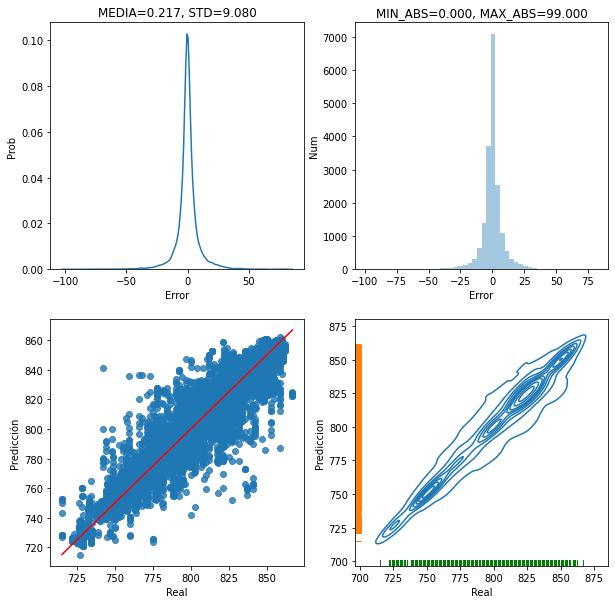

In [18]:
# Visualiza los errores de validación cruzada 
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

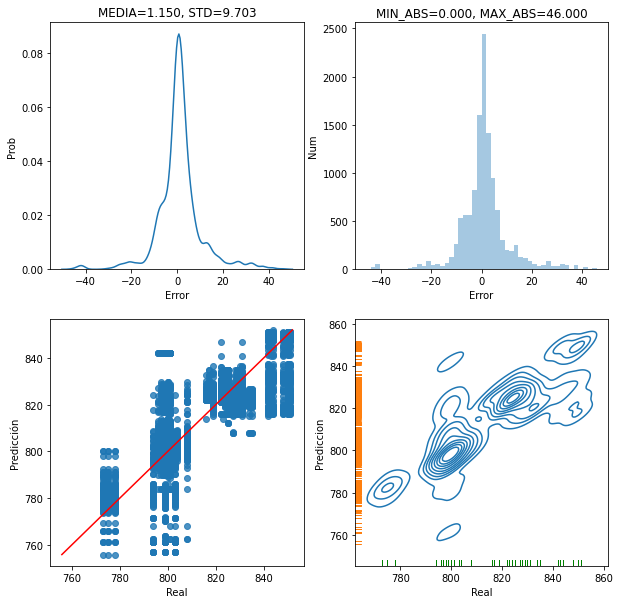

In [19]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = 15
y_true_rep = np.array(list(y_test_tmpp2)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

Dibujamos la simulación del proceso con las predicciones de THC1, THC3, THC5, TMPP2 si fijamos VELMED a 180m/min.

Obtenemos la diferencia máxima entre TMPP2 y TMPP2CNG, y vemos que es menor de los 25ºC. De este modo, la simulación nos indica que todas las bobinas van a poder ser tratadas correctamente.

DIFERENCIA MAXIMA ENTRE TMPP2CNG y TMPP2= 24.248047619047725


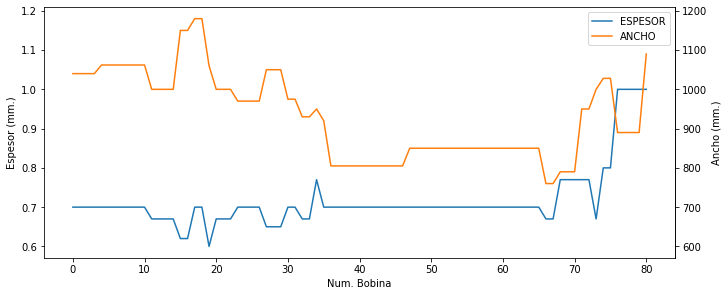

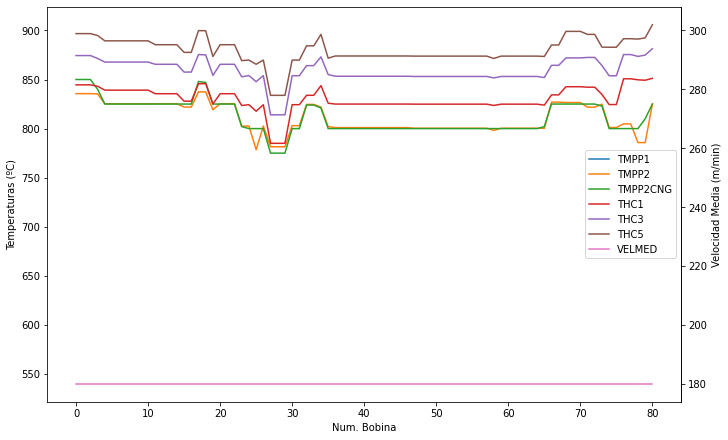

In [20]:
df_test_cat['TMPP2'] = preds_test_tmpp2 #Metemos la predicción de TMPP2
df_test_cat['TMPP1'] = np.nan # no lo sabemos. Lo ponemos a un nan
print('DIFERENCIA MAXIMA ENTRE TMPP2CNG y TMPP2=',np.max(np.abs(df_test_cat['TMPP2CNG']-df_test_cat['TMPP2'])))
dibuja_proceso(df_test_cat[df_test.columns])

## Optimización del Scheduling de Bobinas para Minimizar los Saltos Térmicos de THC1

El segundo objetivo es minimizar los saltos de THC1. Como THC1, THC3 y THC5 están muy correladas entre sí, si minimizamos los saltos de THC1 se minimizarán los saltos térmicos de las otras dos variables. Podemos calcular la suma de la diferencias de temperaturas fácilmente:

In [21]:
def calcula_diff(thc1, var):
    suma_diff = thc1.diff().abs().sum()
    print(f'Suma de differencias en valor absoluto de {var} entre bobinas consecutivas={suma_diff:,.2f}')

calcula_diff(df_test_cat['THC1'],'THC1')
calcula_diff(df_test_cat['THC3'],'THC3')
calcula_diff(df_test_cat['THC5'],'THC5')

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=278.85
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=287.13
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=299.98


La máxima minimización de los saltos de THC1 la obtendríamos ordenando las bobinas según THC1, tal y como se puede observar en las siguientes celdas.

Vemos que el mínimo valor de saltos en THC1 es una suma de 64ºC en total. Sin embargo, vemos que existe un enorme desorden de las bobinas con muchos saltos entre espesores y anchos de bobina.

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=66.18
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=77.56
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=131.89


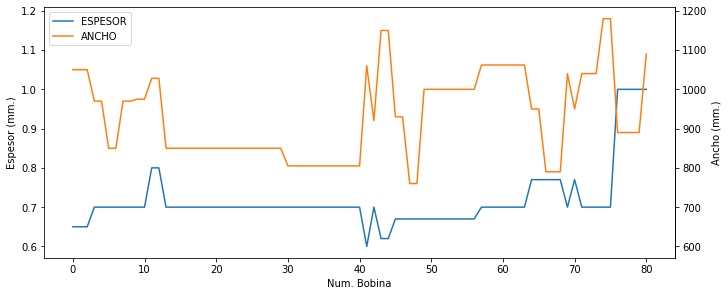

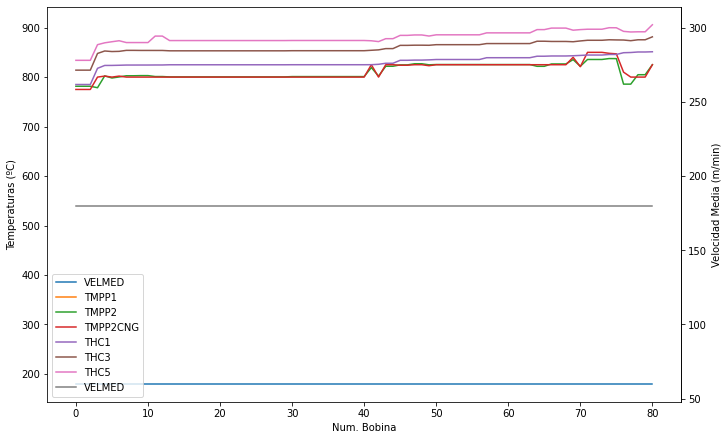

In [22]:
calcula_diff(df_test_cat.sort_values(['THC1'])['THC1'],'THC1')
calcula_diff(df_test_cat.sort_values(['THC1'])['THC3'],'THC3')
calcula_diff(df_test_cat.sort_values(['THC1'])['THC5'],'THC5')

dibuja_proceso(df_test_cat[df_test.columns].sort_values(['THC1']).reset_index())

In [23]:
df_test_cat[df_test.columns].sort_values(['THC1']).head(10)

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
27,23643024,B102G33,1050.0,0.65,3531.0,19130.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889
29,23643026,B102G33,1050.0,0.65,3739.0,20180.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889
28,23643025,B102G33,1050.0,0.65,2881.0,15430.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889
25,23643022,B103G55,970.0,0.70,2767.0,14900.0,180.0,NaN,778.511111,800.0,817.702000,847.770778,865.521556
23,23643020,B102G55,970.0,0.70,2856.0,15430.0,180.0,NaN,802.450651,802.0,823.526778,852.759778,869.271222
58,23643055,K011B55,850.0,0.70,3432.0,15970.0,180.0,NaN,798.176397,800.0,823.588556,851.628000,871.441778
65,23653003,K011F57,850.0,0.70,3352.0,15770.0,180.0,NaN,800.288397,802.0,823.908778,852.005000,873.475556
26,23643023,B102G55,970.0,0.70,2659.0,14260.0,180.0,NaN,802.663095,800.0,824.327556,854.015889,869.793000
24,23643021,B102G55,970.0,0.70,2878.0,15360.0,180.0,NaN,802.663095,800.0,824.327556,854.015889,869.793000
31,23643028,B102G55,975.0,0.70,3633.0,19520.0,180.0,NaN,802.983317,800.0,824.368667,853.858333,869.793000


Sin embargo, a efecto prácticos, **es conveniente reorganizar las bobinas de modo que las dimensiones en ancho y espesor no difieran mucho unas de otras pues las bobinas se desenrollan y van soldadas una detrás de otra. Si se sueldan bobinas con dimensiones muy diferentes, las soldaduras pueden romperse y generar paradas en el proceso que son muy costoss**. Así mismo, el tipo de acero es importante que sea lo más constante posible.

En el ejemplo siguiente, intentamos ordenar en base a THC1 redondeado, el ancho redondeado, el espesor redondeado y el tipo de acero. Según las variables elegidas podemos ordenar el *scheduling* de bobinas a procesar. El redondeo permite agrupar las bobinas con dimensiones parecidas o THC1 parecidas.

Según la estrategia de ordenamiento y el tipo de redondeo que hagamos, podemos realizar un tipo de orden u otro.

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=140.21
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=153.75
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=176.37
Suma de differencias en valor absoluto de ANCHO entre bobinas consecutivas=2,640.00
Suma de differencias en valor absoluto de ESPESOR entre bobinas consecutivas=0.75


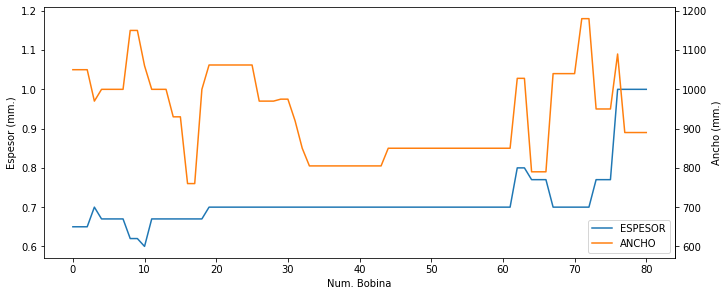

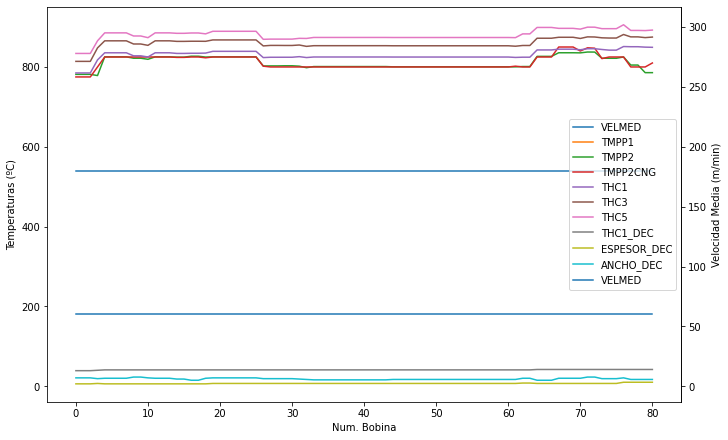

In [24]:
df_sort = df_test_cat[df_test.columns].copy()
df_sort['THC1_DEC'] = df_sort['THC1']//20 #El divisor puede modificarse para agrupar menos o más 
df_sort['ESPESOR_DEC'] = df_sort['ESPESOR']*10//1 #El divisor puede modificarse para agrupar menos o más
df_sort['ANCHO_DEC'] = df_sort['ANCHO']//50 #El divisor puede modificarse para agrupar menos o más
# print(df_sort.head(3))
df_sort = df_sort.sort_values(['THC1_DEC','ESPESOR_DEC','CLASACERO']).reset_index()
calcula_diff(df_sort['THC1'],'THC1')
calcula_diff(df_sort['THC3'],'THC3')
calcula_diff(df_sort['THC5'],'THC5')
calcula_diff(df_sort['ANCHO'],'ANCHO')
calcula_diff(df_sort['ESPESOR'],'ESPESOR')
dibuja_proceso(df_sort)

Esta es la lista de las bobinas ordenadas

In [25]:
df_sort.head(10)

,index,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5,THC1_DEC,ESPESOR_DEC,ANCHO_DEC
0,27,23643024,B102G33,1050.0,0.65,3531.0,19130.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889,39.0,6.0,21.0
1,28,23643025,B102G33,1050.0,0.65,2881.0,15430.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889,39.0,6.0,21.0
2,29,23643026,B102G33,1050.0,0.65,3739.0,20180.0,180.0,NaN,781.471762,775.0,785.010333,814.023111,833.881889,39.0,6.0,21.0
3,25,23643022,B103G55,970.0,0.70,2767.0,14900.0,180.0,NaN,778.511111,800.0,817.702000,847.770778,865.521556,40.0,7.0,19.0
4,11,23643008,B100F55,1000.0,0.67,3129.0,16570.0,180.0,NaN,825.358302,825.0,835.525889,865.506000,885.447000,41.0,6.0,20.0
5,12,23643009,B100F55,1000.0,0.67,3132.0,16500.0,180.0,NaN,825.358302,825.0,835.525889,865.506000,885.447000,41.0,6.0,20.0
6,13,23643010,B100F55,1000.0,0.67,3174.0,16840.0,180.0,NaN,825.358302,825.0,835.525889,865.506000,885.447000,41.0,6.0,20.0
7,14,23643011,B100F55,1000.0,0.67,3152.0,16580.0,180.0,NaN,825.358302,825.0,835.525889,865.506000,885.447000,41.0,6.0,20.0
8,15,23643012,B100F55,1150.0,0.62,1850.0,10500.0,180.0,NaN,821.920238,825.0,827.936222,857.566667,877.631000,41.0,6.0,23.0
9,16,23643013,B100F55,1150.0,0.62,1770.0,9930.0,180.0,NaN,821.920238,825.0,827.936222,857.566667,877.631000,41.0,6.0,23.0


**EJERCICIO: Buscar la forma de ordenar las bobinas para que**:

- La suma de differencias en valor absoluto de THC1 entre bobinas consecutivas sea < 100
- La suma de differencias en valor absoluto de THC3 entre bobinas consecutivas sea < 110
- La suma de differencias en valor absoluto de THC5 entre bobinas consecutivas sea < 120
- La suma de differencias en valor absoluto de ANCHO entre bobinas consecutivas sea < 2800
- La suma de differencias en valor absoluto de ESPESOR entre bobinas consecutivas sea < 1.8

**Saca la lista completa de bobinas ordenadas y dibuja la simulación del proceso final.**

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=84.47
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=96.00
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=119.00
Suma de differencias en valor absoluto de ANCHO entre bobinas consecutivas=2,780.00
Suma de differencias en valor absoluto de ESPESOR entre bobinas consecutivas=1.09


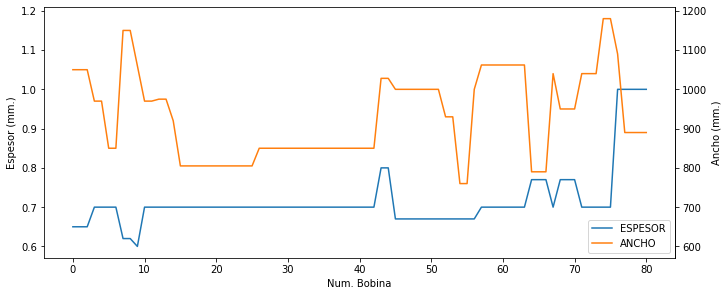

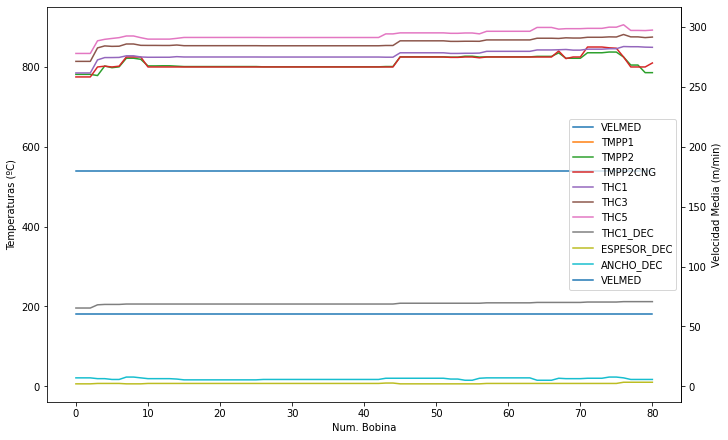

In [26]:
df_sort = df_test_cat[df_test.columns].copy()
df_sort['THC1_DEC'] = df_sort['THC1']//4 #El divisor puede modificarse para agrupar menos o más 
df_sort['ESPESOR_DEC'] = df_sort['ESPESOR']*10//1 #El divisor puede modificarse para agrupar menos o más
df_sort['ANCHO_DEC'] = df_sort['ANCHO']//50 #El divisor puede modificarse para agrupar menos o más
# print(df_sort.head(3))
df_sort = df_sort.sort_values(['THC1_DEC','ESPESOR_DEC','CLASACERO']).reset_index()
calcula_diff(df_sort['THC1'],'THC1')
calcula_diff(df_sort['THC3'],'THC3')
calcula_diff(df_sort['THC5'],'THC5')
calcula_diff(df_sort['ANCHO'],'ANCHO')
calcula_diff(df_sort['ESPESOR'],'ESPESOR')
dibuja_proceso(df_sort)

He cambiado el divisor de 

df_sort['THC1_DEC'] = df_sort['THC1']//4 #El divisor puede modificarse para agrupar menos o más 

a 4 en lugar de 20 para agruparlo mejor

Lo he hecho ordenando en base a THC1 redondeado

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.